In [1]:
import tensorflow as tf
from tensorflow_similarity.api.engine.simhash import SimHash
import numpy as np
from collections import defaultdict, namedtuple
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# read MNIST example helper method
def read_mnist_data(ways=5):

    (x_train, y_train), (x_test_raw,
                         y_test_raw) = tf.keras.datasets.mnist.load_data()

    x_train = x_train[..., np.newaxis]

    x_tests = []
    y_tests = []

    x_targets = []
    y_targets = []

    seen = defaultdict(int)
    for x, y in zip(x_test_raw, y_test_raw):
        if seen[y] < ways:
            seen[y] += 1
            x_targets.append(x[..., np.newaxis])
            y_targets.append(y)
        else:
            x_tests.append(x[..., np.newaxis])
            y_tests.append(y)

    return (({
        "example": np.array(x_train) / 255.0
    }, np.array(y_train)), ({
        "example": np.array(x_tests) / 255.0
    }, np.array(y_tests)), ({
        "example": np.array(x_targets) / 255.0
    }, np.array(y_targets)))

In [3]:
# display thresholds, precisions, recalls helper method
def display(thresholds, precisions, recalls):
    plt.scatter(thresholds, precisions)
    plt.xlabel("thresholds")
    plt.ylabel("precisions")
    plt.title("precisions vs thresholds")
    plt.show()
    plt.scatter(thresholds, recalls)
    plt.xlabel("thresholds")
    plt.ylabel("recalls")
    plt.title("recalls vs thresholds")
    plt.show()
    plt.scatter(precisions, recalls)
    plt.xlabel("precisions")
    plt.ylabel("recalls")
    plt.title("recalls vs precisions")
    plt.show()

In [4]:
# customize tuples
Match = namedtuple("match", ["distance", "is_correct"])
Point = namedtuple("point", ["threshold", "precision", "recall"])

In [5]:
# computation configs
ways = 5
rounding_precision = 3

In [6]:
## Stage 0: load 

# load tf similarity model and test and target data
model = tf.keras.models.load_model('mnist_model_quad.h5')
_, (x_test, y_test), (x_targets, y_targets) = read_mnist_data(ways)

# build database on target data
database = model.build_database(x_targets, y_targets)
# compute the nearest neighbors (this is default sorted)
results = model.neighbors(x_test, N=len(y_targets))

In [7]:
test_embeddings = model.predict(x_targets)
print(np.sum(test_embeddings[0]))

-0.27563047


In [8]:
## Stage 1: Filter results 

# truncate results so that it only contains matches up to the first correct match
for i in range(len(results)):
    first_correct_index = 0
    correct_label = y_test[i]
    neighbors = results[i]
    while neighbors[first_correct_index].label != correct_label:
        first_correct_index += 1
    truncated_result = neighbors[:first_correct_index+1]
    results[i] = truncated_result

matches = []
# combine results from list of list of NearestNighbors to list of (distance, is_correct)
for i, neighbors in enumerate(results):
    correct_label = y_test[i]
    for neighbor in neighbors:
        match = Match(neighbor.distance, neighbor.label == correct_label)
        matches.append(match)

# sort matches
matches = sorted(matches, key=lambda match: match.distance)

In [9]:
## Stage 2: Compute thresholds, precisions, recalls

# combine (thresholds, accuracy, recall)
correct_examples = 0
seen_examples =  0
total_examples = len(y_test) # num example in the dataset * num neighbour
all_data = []
for r in matches:
    
    threshold, verdict = r
    if verdict:
        correct_examples += 1
    seen_examples += 1
    
    # metrics
    threshold = round(threshold, rounding_precision)
    accuracy = round(correct_examples / seen_examples, rounding_precision)
    recall = round(correct_examples / total_examples, rounding_precision)
    
    point = Point(threshold, accuracy, recall)
    all_data.append(point)

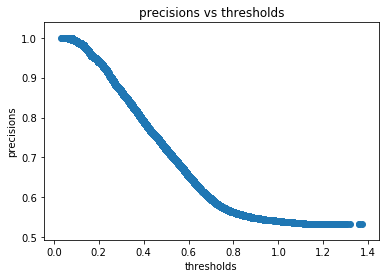

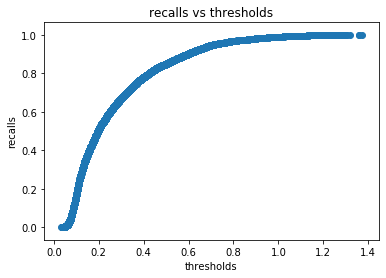

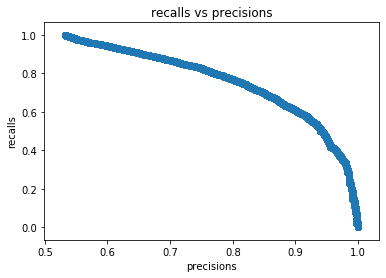

In [10]:
# display
thresholds = np.asarray([point.threshold for point in all_data])
precisions = np.asarray([point.precision for point in all_data])
recalls = np.asarray([point.recall for point in all_data])
display(thresholds, precisions, recalls)

In [11]:
## Stage 3: Pick Thresholds
desired_precisions = np.asarray([0.99, 0.90, 0.80, 0.70])
corresponding_thresholds = []
corresponding_recalls = []

for desired_precision in desired_precisions:
    index = (np.abs(precisions - desired_precision)).argmin()
    corresponding_threshold = thresholds[index]
    corresponding_recall = recalls[index]
    corresponding_thresholds.append(corresponding_threshold)
    corresponding_recalls.append(corresponding_recall)

print("desired_precisions: {}".format(desired_precisions))
print("corresponding_thresholds: {}".format(corresponding_thresholds))
print("corresponding_recalls: {}".format(corresponding_recalls))

desired_precisions: [0.99 0.9  0.8  0.7 ]
corresponding_thresholds: [0.103, 0.255, 0.387, 0.53]
corresponding_recalls: [0.186, 0.607, 0.768, 0.867]
